# Big Data in Finance: Assignment

## Renee Djatmiko,  Steven Kingaby, Liu Zehua, Han Zuosong, Ingrid Zhou

In [73]:
from datetime import datetime
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, LassoCV
from statistics import mean

In [78]:
# Toggle this value to false when debugging. Significantly reduces computation time, 
# but at the same time significantly reduces accuracy of output.
is_debug_mode = True

# Globally define models (bit messy, change this - was just a quick hack to avoid 
# reinstantiating the same model at the date level).
linear_regression_model = LinearRegression()
lasso_regression_model = LassoCV(cv = 10, selection = 'random', random_state = 0, n_alphas = 10)

# Hyperparameters
window_size = 252 # Number of working days in a year.

In [3]:
permno_tickers_df = pd.read_excel('PERMNO_Tickers.xlsx')
trading_flows_df = pd.read_excel('Flows_Clean.xlsx')
stock_returns_df = pd.read_excel('Returns_Clean.xlsx')

print(stock_returns_df)

         Dates     55976     41072     27748     75259     40970     62519  \
0     19930401 -0.019685  0.019391 -0.007282 -0.003891  0.083333  0.027027   
1     19930402 -0.020080  0.002717 -0.002445  0.058594 -0.038462 -0.026316   
2     19930405 -0.024590 -0.006775 -0.002451  0.022140 -0.040000  0.027027   
3     19930406 -0.067227  0.009550 -0.007371  0.025271  0.041667  0.052632   
4     19930407  0.000000  0.005405  0.000000  0.021127  0.040000 -0.050000   
...        ...       ...       ...       ...       ...       ...       ...   
1953  20001222  0.014493  0.025678  0.003630  0.077551  0.000000  0.011811   
1954  20001226 -0.035714  0.034771  0.007233 -0.056818 -0.063830  0.060311   
1955  20001227  0.038272  0.001344  0.001795  0.000000  0.090909 -0.042202   
1956  20001228  0.007134  0.055034 -0.003584  0.052209 -0.020833  0.063218   
1957  20001229  0.003542 -0.022901  0.032374 -0.049618  0.148936 -0.018018   

         21792     54084     55511  ...     63829     44986    

In [75]:
#### Utility Functions ####

def get_permno_tickers(permno_tickers_df):
    """
    Returns an array of the PERMNO tickers.
    """

    return list(dict.fromkeys(permno_tickers_df["PERMNO"].values))

def get_dates(df):
    """
    Returns an array of the date values in their original integer form.
    """

    return list(df["Dates"].values)

def get_rmse(actual_returns, predicted_returns):
    """
    Returns the root mean squared error of the predicted returns.
    """
    return sqrt(mean_squared_error(actual_returns, predicted_returns))

def get_sum_squared_errors(actual_returns, predicted_returns):
    """
    Returns sum of the squared errors.
    """

    return sum([(actual_returns[i] - predicted_returns[i]) ** 2 for i in range(len(actual_returns))])

def get_r_squared(actual_returns, mean_predicted_returns, model_predicted_returns):
    """
    Returns the R^2 of the predicted returns. Will return 'NaN' if the given lists are singletons or empty.
    """

    mean_sum_squared_errors = get_sum_squared_errors(actual_returns, mean_predicted_returns)
    model_sum_squared_errors = get_sum_squared_errors(actual_returns, model_predicted_returns)

    return 1 - model_sum_squared_errors / mean_sum_squared_errors

def build_training_set(regressors):
    """
    Reshape regressor values so it corresponds to (n_samples x n_feature) dimensions.
    Arguments to the regression model `fit` and `predict` functions require this shape.
    # """

    regressors = [list(regressor) for regressor in regressors] # (n_feature x n_samples) 
    training_set = np.array(regressors) 

    return training_set.transpose() # (n_samples x n_feature) 


In [76]:
#### Regression Model Calculations ####

def get_returns(permno_tickers, stock_returns_df, trading_flows_df, date_idx, window_size):
    """
    Returns dictionary of returns where the keys are a string representing the type of return and
    the value is an actual/predicted returns for given tickers at the date corresponding to `date_idx`.
    """
    
    returns = {
        'actual': [],
        'mean': [],
        'model': []
    }

    for ticker in permno_tickers:
        returns['actual'].append(get_actual_returns(ticker, stock_returns_df, date_idx, window_size))
        returns['mean'].append(get_historical_mean_return(ticker, stock_returns_df, date_idx, window_size))
        returns['model'].append(get_warm_up_regression_return(lasso_regression_model, ticker, permno_tickers, stock_returns_df, trading_flows_df, date_idx, window_size))

    return returns

def get_actual_returns(ticker, stock_returns_df, date_idx, window_size):
    """
    Returns the actual returns for a given ticker and window.
    """
    return stock_returns_df.iloc[date_idx].loc[ticker]

def get_historical_mean_return(ticker, stock_returns_df, date_idx, window_size):
    """
    Returns the historical mean return for a given ticker and window.
    """
    returns = stock_returns_df.iloc[date_idx - window_size:date_idx].loc[:, ticker]

    return mean(returns)

def get_autoregression_return(model, ticker, permno_tickers, stock_returns_df, trading_flows_df, date_idx, window_size):
    """
    Returns the autoregression return for a given ticker and window.

    This was the first warm up regression in the coursework spec.

    Regression Equation: r_t = r_{t-1}
    """
    # Lag values.
    lag_one = 1

    # Start fetching the relevant data to fit the model.
    training_set = {}
    training_set['y_samples'] = stock_returns_df.iloc[date_idx - window_size:date_idx].loc[:, ticker]

    lagged_returns_1 = stock_returns_df.iloc[date_idx - window_size - lag_one:date_idx - lag_one].loc[:, ticker]
    training_set['x_samples'] = build_training_set(lagged_returns_1)

    # Fit the model.
    model.fit(training_set['x_samples'], training_set['y_samples'])
    
    # One sample in the test set.
    test_set = [[
        stock_returns_df.iloc[date_idx - lag_one].loc[ticker],
    ]]

    # # Debugging Code
    # linear_regression_model.fit(training_set['lagged_returns_1'], training_set['returns'])
    # predicted_returns = linear_regression_model.predict(training_set['lagged_returns_1'])
    # plt.scatter(training_set['lagged_returns_1'], training_set['returns'], color='black')
    # plt.plot(training_set['lagged_returns_1'], predicted_returns, color='blue')

    model_return = model.predict(test_set)

    return model_return[0]

def get_warm_up_regression_return(model, ticker, permno_tickers, stock_returns_df, trading_flows_df, date_idx, window_size):
    """
    Returns the regressions that corrsponds to the following regression equation for a given ticker and window.

    This was the first warm up regression in the coursework spec.

    Regression Equation: r_t = r_{t-1} + r_{t-2} + r_{t-3} + f_{t-1} + f_{t-2} + f_{t-3} + cross sectional returns and flows up to lag 3
    """
    # Lag values.
    lag_one = 1
    lag_two = 2
    lag_three = 3

    # Start fetching the relevant data to fit the model.
    training_set = {}
    training_set['y_samples'] = stock_returns_df.iloc[date_idx - window_size:date_idx].loc[:, ticker]

    lagged_returns_1 = stock_returns_df.iloc[date_idx - window_size - lag_one:date_idx - lag_one].loc[:, ticker]
    lagged_returns_2 = stock_returns_df.iloc[date_idx - window_size - lag_two:date_idx - lag_two].loc[:, ticker]
    lagged_returns_3 = stock_returns_df.iloc[date_idx - window_size - lag_three:date_idx - lag_three].loc[:, ticker]
    lagged_flows_1 = trading_flows_df.iloc[date_idx - window_size - lag_one:date_idx - lag_one].loc[:, ticker]
    lagged_flows_2 = trading_flows_df.iloc[date_idx - window_size - lag_two:date_idx - lag_two].loc[:, ticker]
    lagged_flows_3 = trading_flows_df.iloc[date_idx - window_size - lag_three:date_idx - lag_three].loc[:, ticker]

    regressors = [        
        lagged_returns_1,
        lagged_returns_2,
        lagged_returns_3,
        lagged_flows_1,
        lagged_flows_2,
        lagged_flows_3
    ]

    # One sample in the test set.
    test_set = [[
        stock_returns_df.iloc[date_idx - lag_one].loc[ticker],
        stock_returns_df.iloc[date_idx - lag_two].loc[ticker],
        stock_returns_df.iloc[date_idx - lag_three].loc[ticker],
        trading_flows_df.iloc[date_idx - lag_one].loc[ticker],
        trading_flows_df.iloc[date_idx - lag_two].loc[ticker],
        trading_flows_df.iloc[date_idx - lag_three].loc[ticker],
    ]]

    # Add cross sectional returns and flows up to lag 3 to regressors array and test set.
    for other_ticker in permno_tickers:
        if ticker == other_ticker:
            continue

        other_lagged_returns_1 = stock_returns_df.iloc[date_idx - window_size - lag_one:date_idx - lag_one].loc[:, other_ticker]
        other_lagged_returns_2 = stock_returns_df.iloc[date_idx - window_size - lag_two:date_idx - lag_two].loc[:, other_ticker]
        other_lagged_returns_3 = stock_returns_df.iloc[date_idx - window_size - lag_three:date_idx - lag_three].loc[:, other_ticker]
        other_lagged_flows_1 = trading_flows_df.iloc[date_idx - window_size - lag_one:date_idx - lag_one].loc[:, other_ticker]
        other_lagged_flows_2 = trading_flows_df.iloc[date_idx - window_size - lag_two:date_idx - lag_two].loc[:, other_ticker]
        other_lagged_flows_3 = trading_flows_df.iloc[date_idx - window_size - lag_three:date_idx - lag_three].loc[:, other_ticker]

        regressors.append(other_lagged_returns_1)
        regressors.append(other_lagged_returns_2)
        regressors.append(other_lagged_returns_3)
        regressors.append(other_lagged_flows_1)
        regressors.append(other_lagged_flows_2)
        regressors.append(other_lagged_flows_3)

        # Append relevant regressors to test set
        test_set[0].append(stock_returns_df.iloc[date_idx - lag_one].loc[other_ticker])
        test_set[0].append(stock_returns_df.iloc[date_idx - lag_two].loc[other_ticker])
        test_set[0].append(stock_returns_df.iloc[date_idx - lag_three].loc[other_ticker])
        test_set[0].append(trading_flows_df.iloc[date_idx - lag_one].loc[other_ticker])
        test_set[0].append(trading_flows_df.iloc[date_idx - lag_two].loc[other_ticker])
        test_set[0].append(trading_flows_df.iloc[date_idx - lag_three].loc[other_ticker])

    training_set['x_samples'] = build_training_set(regressors)

    # Fit the model.
    model.fit(training_set['x_samples'], training_set['y_samples'])
    
    model_return = model.predict(test_set)

    return model_return[0]

In [79]:
#### Main Python function that outputs performance metrics ####

def build_performance_df(stock_returns_df, trading_flows_df, permno_tickers_df, window_size, max_lag = 3):
    """
    Builds a dataframe capture performance metrics like RMSE about the model.
    """
    dates = get_dates(stock_returns_df)
    start_date_idx = max_lag + window_size
    num_dates = len(dates)

    permno_tickers = get_permno_tickers(permno_tickers_df)

    if is_debug_mode:
        # Significantly reduces computation time at cost of accuracy.
        permno_tickers = permno_tickers[:2]
        # permno_tickers = [55976]
        # pass

    # Return if the window size is too large.
    if start_date_idx > len(stock_returns_df):
        return

    performance_dates = []
    mean_returns_rmses = []
    model_returns_rmses = []
    rmse_diffs = []
    cumulative_rmse_diffs = []
    r_squared_values = []

    # Iterate through the dataframes, calculating the RMSE differential 
    # row by row, one at a time.
    for date_idx in range(start_date_idx, num_dates):
        returns = get_returns(permno_tickers, stock_returns_df, trading_flows_df, date_idx, window_size)
        # print(returns)

        # RMSE values
        mean_returns_rmse = get_rmse(returns['actual'], returns['mean'])
        model_returns_rmse = get_rmse(returns['actual'], returns['model'])
        rmse_diff = mean_returns_rmse - model_returns_rmse
        cumulative_rmse_diff = rmse_diff if len(cumulative_rmse_diffs) == 0 else rmse_diff + cumulative_rmse_diffs[-1]

        # R^2 value
        r_squared_value = get_r_squared(returns['actual'], returns['mean'], returns['model'])

        # Record all performance metrics.
        performance_dates.append(dates[date_idx])
        mean_returns_rmses.append(mean_returns_rmse)
        model_returns_rmses.append(model_returns_rmse)
        rmse_diffs.append(rmse_diff)
        cumulative_rmse_diffs.append(cumulative_rmse_diff)
        r_squared_values.append(r_squared_value)

    # Reformat integer-based date index into datetime objects.
    performance_dates = [datetime.strptime(str(date), '%Y%m%d') for date in performance_dates]

    performance_data = {
        'mean_returns_rmse': mean_returns_rmses,
        'model_returns_rmse': model_returns_rmses,
        'rmse_differential': rmse_diffs,
        'cumulative_rmse_differential': cumulative_rmse_diffs,
        'r_squared': r_squared_values,
    }
    performance_df = pd.DataFrame(data = performance_data, index = performance_dates)
    
    return performance_df

performance_df = build_performance_df(stock_returns_df, trading_flows_df, permno_tickers_df, window_size)
print(performance_df)

KeyboardInterrupt: 

<AxesSubplot:title={'center':'R^2'}>

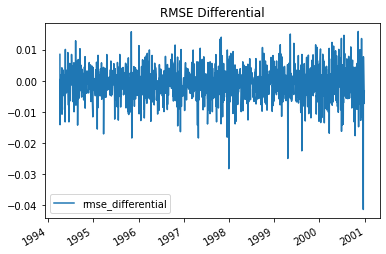

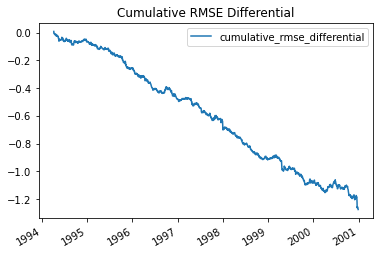

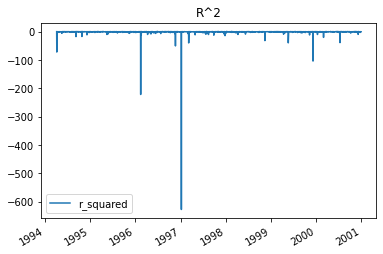

In [69]:
performance_df.plot(y = ['rmse_differential'], title = 'RMSE Differential')
performance_df.plot(y = ['cumulative_rmse_differential'], title = 'Cumulative RMSE Differential')
performance_df.plot(y = ['r_squared'], title = 'R^2')
